# Estimation des paramètres libres 

## Tâche expérimentale et modèle
La tâche que nous utilisons pour illuster l'estimation des paramètres libres est celle des slot-machines. Nous allons utiliser le modèle Q-learning vu dans les cours sur les simulations.




## Estimation des paramètres

L'idée de l'estimation des paramètres libres est de réussir à identifier la valeur des paramètres du modèle (le taux d'apprentissage et la température) qui génèrent des choix qui ressemblent le plus possible à ceux du participant.



## Méthode 1: Grid Search

La première méthode que nous allons utiliser est celle du "grid search", qui consiste à simuler la probabilité de choix du modèle et voir à quel point elle décrit bien le comportement du participant.

D'un point de vue pratique, la méthode du "grid search" consiste à générer les probabilités de choix du modèle avec toutes les combinaisons de paramètres ($ \alpha $ et $ \beta $) possibles, et voir à quel point cela décrit bien le comportement du participant (en calculant la vraisemblance des données) et de sélectionner la paire qui génère les prédictions du modèle qui correspondent ("fit") le mieux au comportement observé.

D'un point de vue théorique, le but de la méthode "grid search" est de trouver les valeurs des paramètres libres ($ \alpha $ et $ \beta $) qui maximisent la probabilité des données observées (les choix du participant), étant donné le modèle que nous avons (Qmodel). 

$$
p(data | model)
$$

Cette quantité est aussi connue comme la vraisemblance (*likelihood*) des données.




### Code du "Grid Search" pour le Qmodel avec plusieurs blocs d'apprentissage

Dans cette partie du code nous allons faire appel à des fonctions. Dans cette partie, il nous suffit de savoir que nous avons deux dossiers qui contiennent deux fonctions différentes auxquelles nous allons faire appel plus tard :

- **dans le dossier "my_models" :** il y a une fonction qui s'appelle Qmodel, qui produit des choix simulés du modèle avec certains paramètres libres (`alpha` et `inv_temp`) et certaines caractéristiques de la tâche expérimentale comme le nombre d'essais (`ntrials`) et le nombre de blocs d'apprentissage (`nruns`).

- **dans le dossier "my_functions" :** il y a une fonction qui s'appelle estimateQ_gridsearch qui exécute le grid search pour trouver les meilleures valeurs des paramètres libres du Qmodel, étant donné les choix (`ch`) et l'historique des récompenses obtenues (`r`) ainsi que les caractéristiques de la tâche (`nruns`) d'un certain participant.



### Code étape 1 : définir ou trouver les fonctions 

Attention, pour que cela marche, il faux exécuter le script à partir du dossier "3-estimer_parametres".

In [23]:
here = pwd;

home = fullfile(here)

addpath(genpath(fullfile(home,'my_models')));
addpath(genpath(fullfile(home,'my_functions')));


home = '/Users/pool/Documents/Teaching/PA/AdvanceSignal/code/3-estimer_parametres'

Vérifiez bien que la variable *"here"* corresponde au chemin où le dossier "3-estimer_parametres" se trouve sur votre ordinateur.

### Code étape 2 : définir les caractéristiques de la tâche

Nombre d'essais et nombre de blocs d'apprentissage :

In [24]:
ntrials =  100;
nruns   =  10;

### Code étape 3: créer un participant synthétique

Nous n'avons pas de vraies données, nous allons simuler des choix d'un participant synthétique (`sim_ch`) avec deux valeurs de paramètres libres que nous allons fixer au préalable. Dans un cas normal, nous ne connaissons pas ces paramètres et nous mesurons simplement les choix des participants.

La fonction Qmodel a comme variables input :
- la valeur de $\alpha$ : `sim_alpha`
- la valeur de $\beta$ : `sim_inv_temp`
- le nombre d'essais : `ntrials`
- le nombre de blocs d'apprentissage : `nruns`

Et comme variables output elle va renvoyer :
- les choix du participant simulé : `sim_ch`
- l'historique des récompenses délivrées à ce participant pendant la tâche : `sim_r`


In [25]:
sim_alpha    = 0.2;
sim_inv_temp = 3;


[sim_ch, sim_r] = Qmodel (sim_alpha, sim_inv_temp, ntrials, nruns);


Attention, la fonction est stochastique et génère des séries temporelles similaires mais différentes à chaque fois.

### Code étape 4: faire un "Grid Search" pour trouver les valeurs des paramètres libres qui décrivent le mieux les choix du participant (synthétique)

Le résultat du grid search est une carte de la somme négative de la vraisemblance transformée en log (negative log likelihood, nLL) pour toutes les combinaisons des valeurs du taux d'apprentissage et de la température inverse. Le point rouge indique la combinaison de paramètres qui minimise la vraisemblance négative.


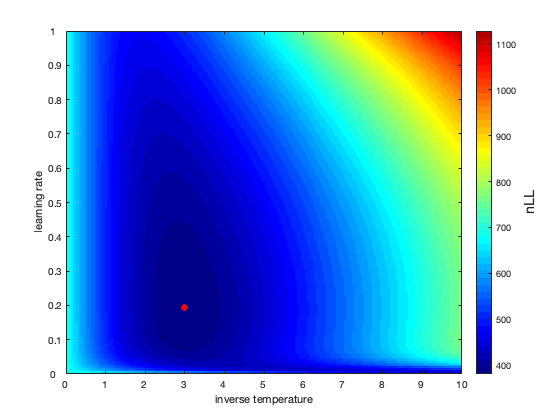

alpha =0.19
inv. temp =3


In [26]:

[est_alpha, est_temp] = estimateQ_gridsearch(sim_ch, sim_r, nruns);

 ### Limites et avantages du "Grid Search"
 
 Cette approche d'estimation a des avantages mais aussi des limites importantes.
 
 Parmi les avantages :
 
 - conceptuellement simple
 - facile à mettre en œuvre 
 - résultats sont faciles à visualiser
 
 Parmi les désavantages :
 
 - n'est pas implémentable avec des modèles ayant plusieurs paramètres libres
 - lourd en temps de calcul et mémoire, même pour des intervalles relativement grossiers
 - pas possible de contraindre vos paramètres en utilisant des "priors informatifs"
 - pas possible d'utiliser des "priors empiriques" (le cadre d'une approche de modèle mixte hiérarchique)
 


 

### Approfondissement du code de la fonction estimateQ_gridsearch

Dans cet approfondissement, nous allons voir en détail le code de la fonction qui exécute le grid search pour le Qmodel. Comme dans MATLAB nous ne pouvons pas définir les fonctions dans le script principal, nous allons légèrement la modifier pour pouvoir exécuter le code.

Premièrement, nous allons mettre la déclaration de la fonction en commentaire :

In [21]:
% function [est_alpha, est_temp] = estimateQ_gridsearch(ch, r, nruns)

Ensuite, nous allons définir les variables qui sont normalement entrées comme input de la fonction :

In [27]:
ch    = sim_ch;
r     = sim_r;


Maitenant, nous pouvons exécuter le code de la fonction ligne par ligne. Nous commençons avec les caractéristiques de la tâche.

In [28]:
% définir la valeur initiale
Q0  = [0 0]; 

% nombre d'essais
ntrials = size(ch,1); % on détermine le nombre d'essais à partir du nombre de choix du participant


Ensuite, on détermine les valeurs possibles des paramètres libres que nous voulons explorer.

In [30]:
% taux d'apprentissage alpha varie entre 0 et 1 avec 201 étapes
alpha_mat = linspace(0,1, 201);

% température inverse varie entre 0 et 1 avec 201 étapes
temp_mat  = linspace(0, 10, 201);

Selon l'espace que nous avons défini ci-dessus, nous initialisons une matrice vide dans laquelle nous allons sauvegarder la vraisemblance (negative log-likelihood, nLL) de chaque combinaison de paramètres.

In [31]:
% initialiser la matrice de vraisemblance pour chaque combinaison de paramètres
nLL = NaN(numel(alpha_mat),numel(temp_mat));

Tout est prêt pour commencer à explorer l'espace des paramètres que nous avons défini. Nous allons procéder avec deux boucles `for` imbriquées l'une dans l'autre. La première lit de manière séquentielle les valeurs d'alpha et la deuxième les valeurs de la température inverse. Donc, pour une valeur d'alpha, nous allons examiner toutes les valeurs possibles de la température inverse, puis passer à la prochaine valeur d'alpha et ainsi de suite.

Ce qui est important dans cette partie, c'est de comprendre où les simulations du modèle et les données du participant sont comparées : nous utilisons le modèle pour calculer la probabilité de choisir (`PA`), ensuite nous utilisons cette probabilité pour voir si elle prédit bien le choix du participant (`ch`). C'est ainsi que nous calculons la vraisemblance (`lik`) à chaque essai.

À la fin des essais, nous calculons la somme négative de la transformation en log de la vraisemblance à chaque essai.

Attention, quand vous exécutez cette partie du code, cela va prendre longtemps (comme discuté dans les limites de cette approche ci-dessus).

In [32]:
%% explorer

% commençons par explorer la vraisemblance des choix avec toutes les
% combinaisons possibles

for a = 1:size(alpha_mat,2)

    alpha = alpha_mat(a); % sélectionner une valeur possible du taux d'apprentissage


    for b = 1:size(temp_mat,2)

        inv_temp = temp_mat(b); % sélectionner une valeur possible de température


        % initialiser les variables du modèle
        PA = NaN(ntrials,1);
        lik = NaN(ntrials,1);
        Qt = NaN(ntrials,2);
        PE = NaN(ntrials,1);

        % valeur avant le début de l'apprentissage
        Qt(1,:)  = Q0;

        for t = 1:ntrials

            if  mod(t,(ntrials/nruns)) == 0
                % initialiser la valeur pour chaque série
                Qt(t,:)  = Q0;
            end

            % calculer la probabilité de choisir A du modèle
            PA(t)   = 1./(1+exp(-inv_temp.*(Qt(t,2)-Qt(t,1))));

            % voir à quel point le choix du modèle correspond au choix du
            % participant
            if ch(t) == 1 % si le participant a choisi B
                lik(t) = 1 - PA(t);
            elseif ch(t) == 2 % si le participant a choisi A
                lik(t) = PA(t);
            end

            % calculer l'erreur de prédiction sur la base de la récompense
            % délivrée au participant (r)
            PE(t) = r(t) - Qt(t,ch(t));

            % mise à jour de la valeur
            Qt(t+1,ch(t)) = Qt(t,ch(t)) + alpha.*PE(t);    % colonne ch(t) = choisie (1 ou 2)
            Qt(t+1,3-ch(t)) = Qt(t,3-ch(t));               % colonne 3-ch(t) = non choisie (2 ou 1)

        end

        % calculer à quel point les choix du participants étaient probables
        % avec ces paramètres du modèle
        nLL(a,b) = -sum(log(lik(:)));


    end % fin température

end % fin taux d'apprentissage



Maintenant que nous avons les valeurs de la vraisemblance négative pour chaque combinaison, il faut juste trouver la combinaison de paramètres qui a généré la plus petite valeur.

In [48]:
% obtenir les valeurs de alpha et de la température estimées

[I,J] = find(nLL == min(min(nLL)));

est_alpha = alpha_mat(I);
est_temp = temp_mat(J);


Et finalement, nous pouvons visualiser le résultat de l'estimation à travers un graphique.

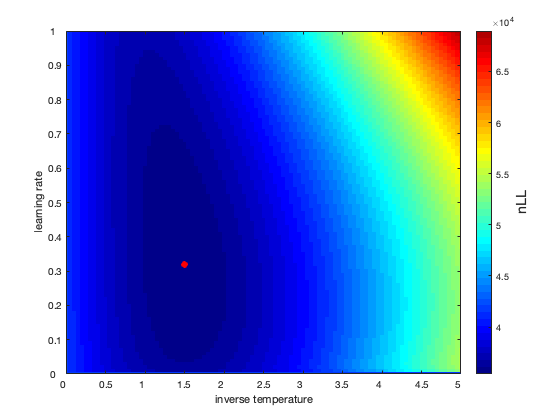

alpha =0.31
inv. temp =1.5


In [49]:
%% plot des résultats du grid search

figure

imagesc(flipud(nLL))
hold on
xlabel('inverse temperature')
ylabel('learning rate')

xt = linspace(1,length(temp_mat),11);
xtl = linspace(min(temp_mat),max(temp_mat),11);

yt = linspace(1,length(alpha_mat),11);
ytl = linspace(min(alpha_mat),max(alpha_mat),11);

set(gca,'XLim',[1 length(temp_mat)],...
    'XTick',xt,...
    'XTickLabel',xtl,...
    'YLim',[1 length(alpha_mat)],...
    'YTick',yt,...
    'YTickLabel',fliplr(ytl))


cb= colorbar();
ylabel(cb,'nLL','FontSize',14)


[I,J] = find(nLL == min(min(nLL)));

disp(strcat('alpha = ',num2str(alpha_mat(I))))
disp(strcat('inv. temp = ',num2str(temp_mat(J))))


plot(J,length(alpha_mat)-I,'o',...
    'MarkerFaceColor',[1,0,0],...
    'MarkerEdgeColor',[1,0,0])



c = jet(50);
colormap(c);

Vous pouvez remarquer que les résultats sont similaires mais pas indentiques à la première fois que nous avons exécuté le grid search, cela est dû à la nature stochastique de la randomisation des essais et du processus qui génère la probabilité de choisir et les choix dans le Qmodel.

## Méthode 2: Utiliser une fonction d'optimisation

La solution typiquement utilisée n'est pas d'explorer systématiquement tout l'espace des paramètres comme dans le grid search, mais d'utiliser une fonction d'optimisation.

Nous allons utiliser une fonction qui existe et qui s'appelle *fminsearch*. Cette fonction permet de trouver la valeur minimale de la fonction (comme par exemple notre modèle) et elle renvoie une valeur scalaire.

Dans notre cas, nous avons la fonction estimateQ qui reçoit comme input les valeurs des paramètres libres et le comportement du participant, et qui renvoie comme output la vraisemblance négative (`nLL`) de ces paramètres par rapport à la modélisation du comportement du participant.

La fonction *fminsearch* commence initialement à un point particulier (que nous devons définir au préalable) et cherche la combinaison de paramètres libres qui permet de minimiser la vraisemblance négative (`nLL`). Elle suit l'approche de l'algorithme du simplexe de Nelder-Mead. 


### Code avec fonction d'optimisation pour le Qmodel avec plusieurs blocs d'apprentissage

Dans cette partie du code nous allons faire appel à des fonctions et modèle que nous avons dans la partie du grid search :


- **dans le dossier "my_models" :** il y a une fonction qui s'appelle Qmodel, qui produit des choix simulés du modèle avec certains paramètres libres (`alpha` et `inv_temp`) et certaines caractéristiques de la tâche expérimentale comme le nombre d'essais (`ntrials`) et le nombre de blocs d'apprentissage (`nruns`).

- **dans le dossier "my_functions" :** il y a une fonction qui s'appelle estimateQ qui nous renvoie la vraisemblance négative, étant donné une combinaison de valeurs des paramètres libres (`param`), des choix (`ch`) et de l'historique des récompenses obtenues (`r`) ainsi que les caractéristiques de la tâche (`nruns`) d'un certain participant.


Nous les avons ajoutés dans le "path" au début de ce code, donc pas besoin de le refaire. De même, nous avons aussi déjà créé les données de notre participant synthétique et défini les paramètres de la tâche.


### Code étape 1: définir le point initial pour le search

In [39]:
x0 = [1 0.1]; % point initial : la première valeur correspond à la température, la deuxième valeur correspond à alpha


### Code étape 2: définir les valeurs limites des nos paramètres libres

In [35]:
xmin = [0 0]; % min : la première valeur correspond à la température, la deuxième valeur correspond à alpha
xmax = [5 1]; % max : la première valeur correspond à la température, la deuxième valeur correspond à alpha

### Code étape 3: définir les paramètres de la fonction d'optimisation

In [38]:
% On définit les options de la fonction d'optimisation
options = optimset('Algorithm', 'interior-point', 'Display', 'iter-detailed', 'MaxIter', 10000); % Ces valeurs augmentent le nombre d'itérations pour s'assurer d'avoir une convergence


### Code étape 4: exécuter la fonction

In [43]:
[parameters,nll,~,~,~]       = fmincon(@(x) estimateQ(x,sim_ch,sim_r, nruns),x0,[],[],[],[],xmin,xmax,[],options);
parameters

                                            First-order      Norm of
 Iter F-count            f(x)  Feasibility   optimality         step
    0       3    3.637139e+04    0.000e+00    3.247e+03
    1       8    3.541273e+04    0.000e+00    1.606e+02    5.197e-01
    2      20    3.541210e+04    0.000e+00    3.657e+01    2.328e-02
    3      25    3.541196e+04    0.000e+00    1.233e+02    1.274e-02
    4      28    3.541173e+04    0.000e+00    3.826e+00    7.464e-03
    5      31    3.541172e+04    0.000e+00    3.233e-01    8.921e-04
    6      34    3.541172e+04    0.000e+00    1.000e-01    6.486e-05
    7      37    3.541172e+04    0.000e+00    2.000e-02    1.233e-05
    8      40    3.541172e+04    0.000e+00    9.630e-03    4.126e-06
    9      43    3.541172e+04    0.000e+00    6.670e-03    1.010e-06
   10      48    3.541172e+04    0.000e+00    8.401e-04    9.392e-07
   11      51    3.541172e+04    0.000e+00    6.513e-03    6.241e-08
   12      58    3.541172e+04    0.000e+00    3

parameters = 1x2 double
    1.4816    0.3114